In [1]:
!pip install fireducks polars modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 16.1.0
    Uninstalling pyarrow-16.1.0:
      Successfully uninstalled pyarrow-16.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatib

In [2]:
import os
import time

# disabling lazy-execution mode of FireDucks and modin
os.environ["FIREDUCKS_FLAGS"] ="--benchmark-mode"
os.environ["MODIN_BENCHMARK_MODE"] = "True"
os.environ["MODIN_ENGINE"] = "ray"

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/zvuk-dataset/zvuk-interactions.parquet
/kaggle/input/zvuk-dataset/zvuk-track_artist_embedding.parquet


In [3]:
results = {}
path = "/kaggle/input/zvuk-dataset/zvuk-interactions.parquet"

def append(lib, *args):
    results[lib] = list(args)
    
    
def bench_polars():
    stime = time.time()
    df = pl.read_parquet(path)
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.drop_nulls()
    dropna_t = time.time() - stime

    stime = time.time()
    fdf = df.filter(pl.col('play_duration') > 0)
    filter_t = time.time() - stime
    
    stime = time.time()
    #avg = df.select(pl.col('play_duration').mean())
    avg = df['play_duration'].mean()
    mean_t = time.time() - stime

    append("polars", load_t, dropna_t, filter_t, mean_t)
    del df
    print(f"[polars] load-time: {load_t} sec; dropna-time: {dropna_t} sec; filter-time: {filter_t} sec; mean-time: {mean_t} sec")


def bench_others(pd):
    stime = time.time()
    df = pd.read_parquet(path)
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.dropna()
    dropna_t = time.time() - stime
    
    stime = time.time()
    fdf = df[df['play_duration'] > 0]
    filter_t = time.time() - stime

    stime = time.time()
    avg = df['play_duration'].mean()
    mean_t = time.time() - stime    
    
    lib = pd.__name__
    append(lib, load_t, dropna_t, filter_t, mean_t)
    del df
    print(f"[{lib}] load-time: {load_t} sec; dropna-time: {dropna_t} sec; filter-time: {filter_t} sec; mean-time: {mean_t} sec")
    
import pandas as pd
import fireducks.pandas as fd
import fireducks
import modin.pandas as md
import polars as pl

from fireducks.core import get_fireducks_options
get_fireducks_options().set_benchmark_mode(True)

import platform, psutil

print("="*30, "Evaluation Environment Information", "="*30)
print(f'platform: {platform.system()}')
print(f'architecture: {platform.machine()}')
print(f'processor: {platform.processor()}')
print(f'cpu: {psutil.cpu_count()}')
print(f'ram: {str(round(psutil.virtual_memory().total / (1024 ** 3)))} GB')
print(f'pandas-version: {pd.__version__}')
print(f'fireducks-version: {fireducks.__version__}')
print(f'modin-version: {md.__version__}')
print(f'polars-version: {pl.__version__}')

import gc

for mod in [pd, fd]:
    bench_others(mod)
    gc.collect()
    
bench_polars()
gc.collect(); 

results = pd.DataFrame.from_dict(results)
results.index = ["load-time", "dropna-time", "filter-time", "mean-time"]
results = round(results, 4)
results

============================== Evaluation Environment Information ==============================
platform: Linux
architecture: x86_64
processor: x86_64
cpu: 4
ram: 31 GB
pandas-version: 2.2.2
fireducks-version: 1.0.0
modin-version: 0.31.0
polars-version: 1.1.0
[pandas] load-time: 28.22659730911255 sec; dropna-time: 6.312413215637207 sec; filter-time: 27.22847580909729 sec; mean-time: 0.43241333961486816 sec
[fireducks.pandas] load-time: 18.13344693183899 sec; dropna-time: 0.002555370330810547 sec; filter-time: 4.447640895843506 sec; mean-time: 0.16196632385253906 sec
[polars] load-time: 9.887712478637695 sec; dropna-time: 0.0790712833404541 sec; filter-time: 1.7644593715667725 sec; mean-time: 0.11053800582885742 sec


,pandas,fireducks.pandas,polars
load-time,28.2266,18.1334,9.8877
dropna-time,6.3124,0.0026,0.0791
filter-time,27.2285,4.4476,1.7645
mean-time,0.4324,0.1620,0.1105


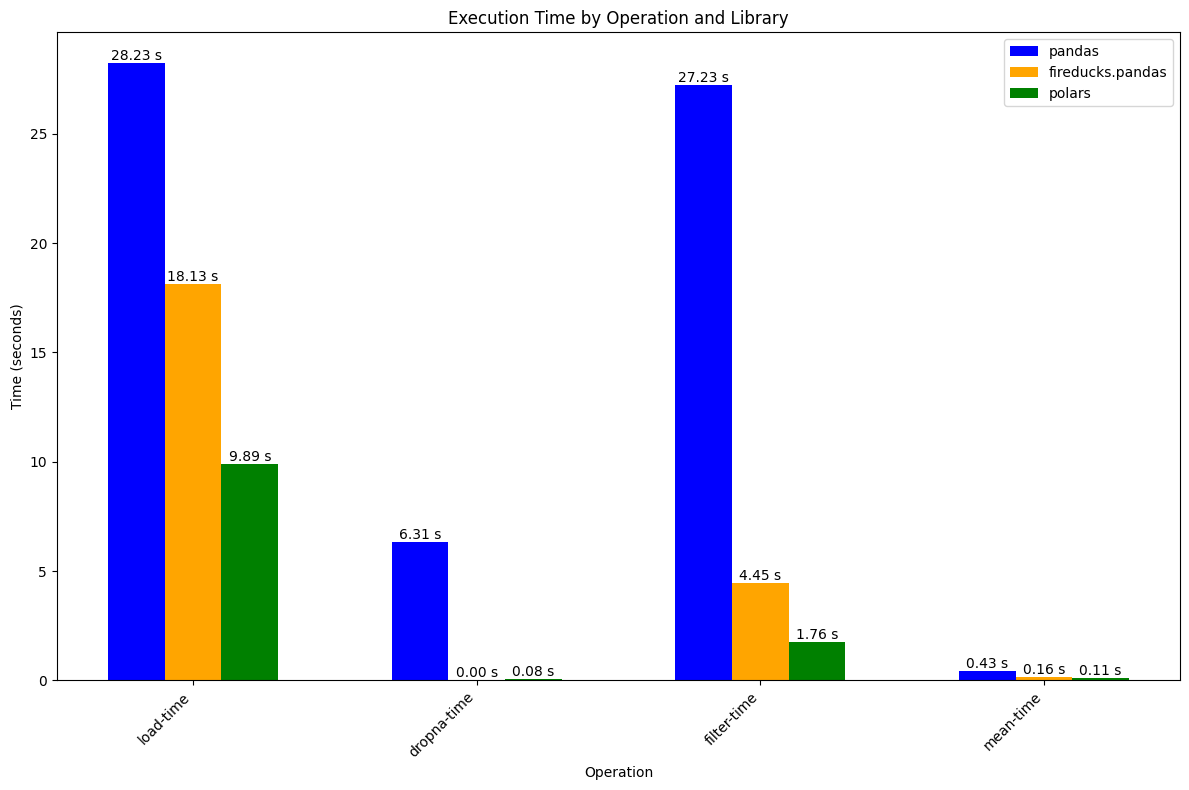

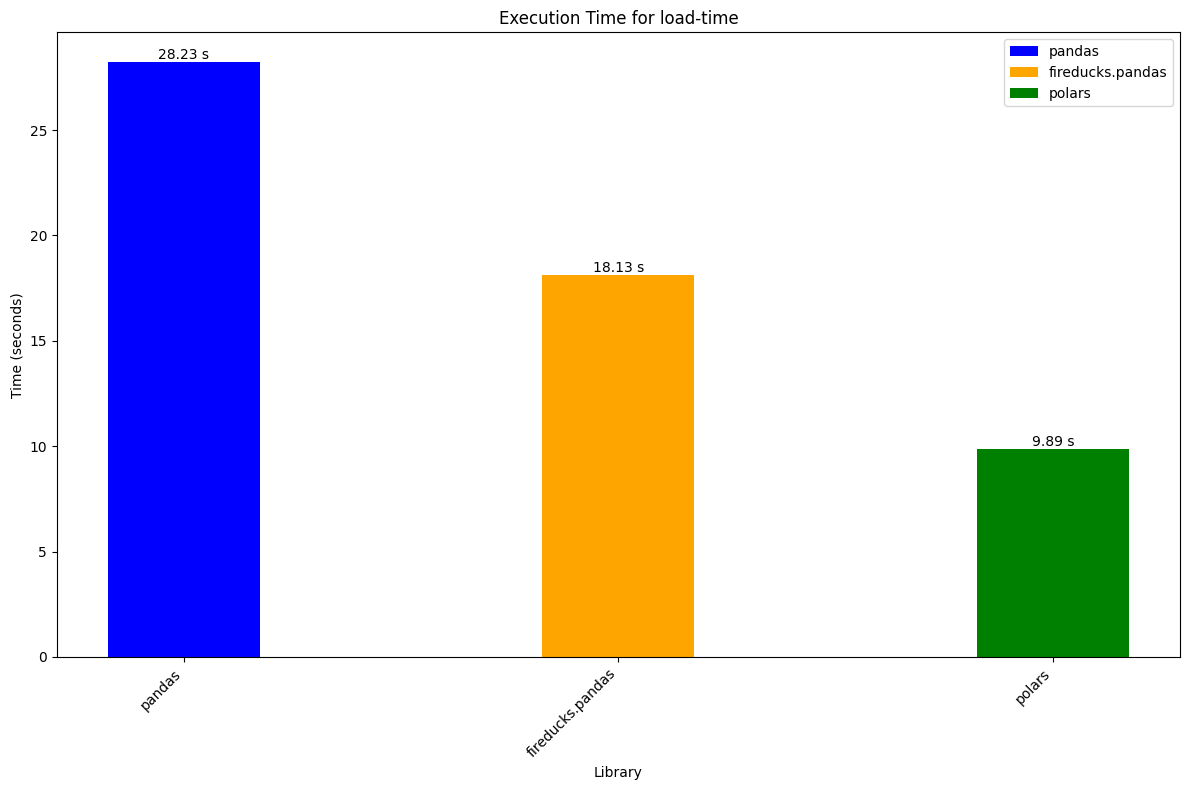

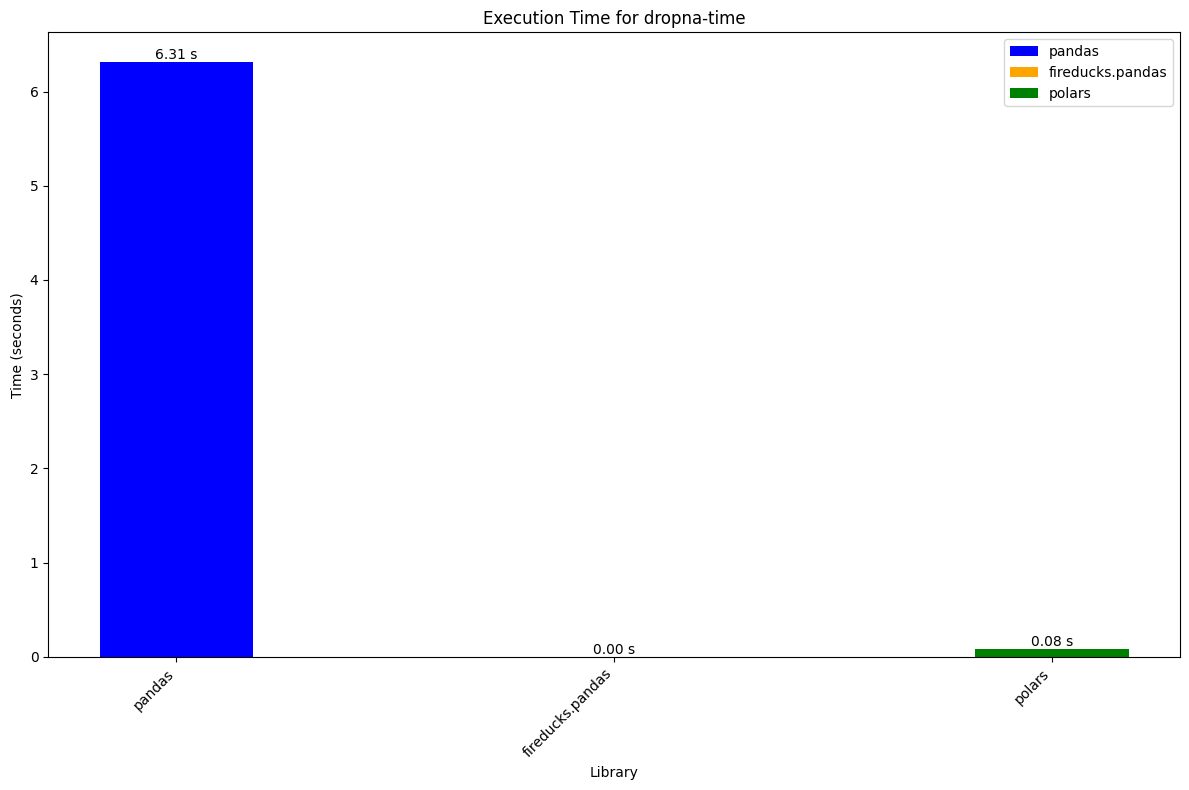

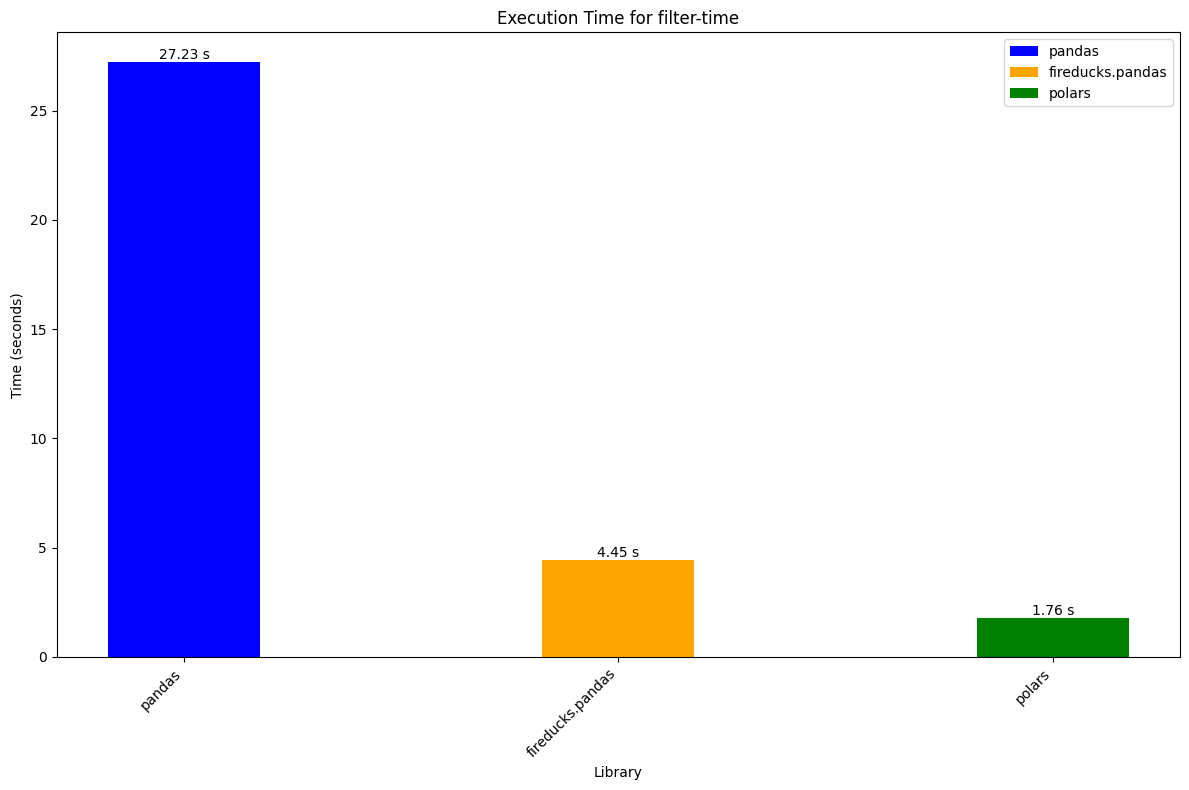

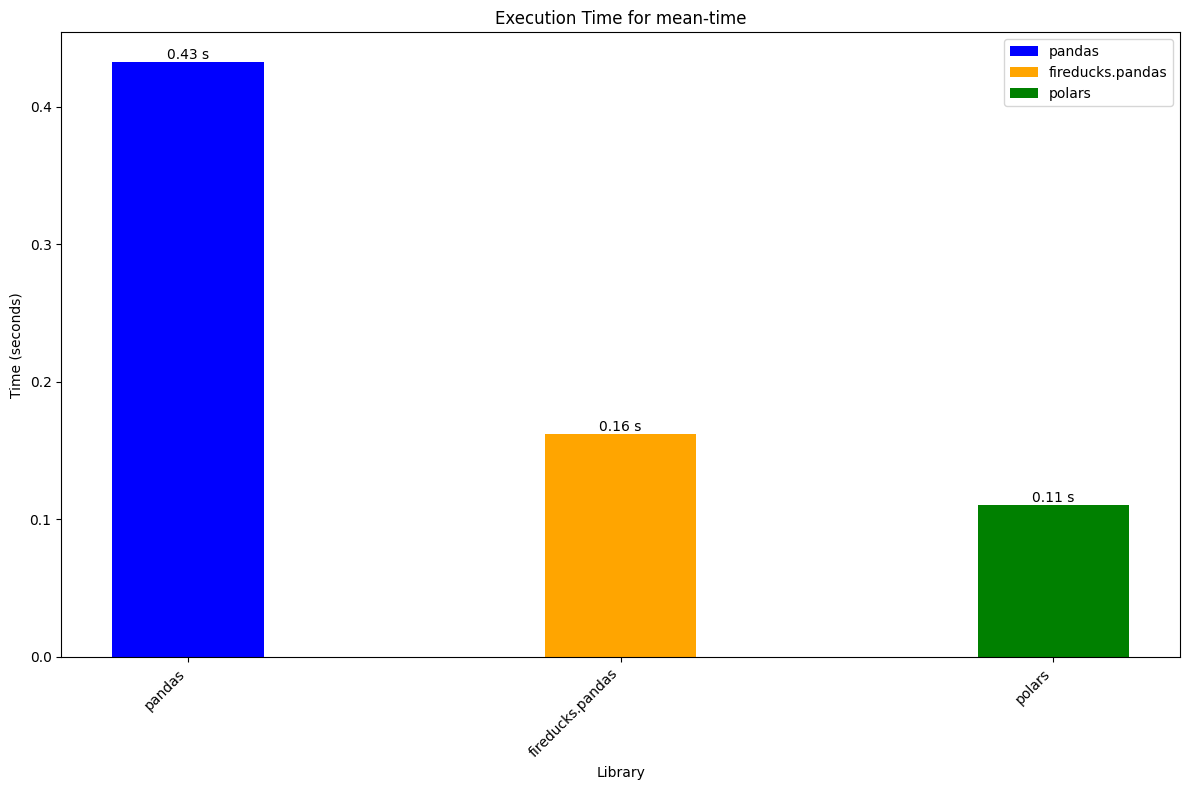

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `results` is your DataFrame
operations = results.index.tolist()
libraries = results.columns.tolist()
colors = ['blue', 'orange', 'green', 'red']  # You can adjust colors as needed

# Combined plot for all operations
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = np.arange(len(operations))

for i, lib in enumerate(libraries):
    times = results[lib].tolist()
    ax.bar(index + i * bar_width, times, bar_width, label=lib, color=colors[i])

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time by Operation and Library')
ax.set_xticks(index + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(operations, rotation=45, ha='right')
ax.legend()

# Add annotations for time
for i, op in enumerate(operations):
    for j, lib in enumerate(libraries):
        lib_time = results[lib][i]
        ax.text(index[i] + j * bar_width, lib_time, f"{lib_time:.2f} s", ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'execution_times_combined.png')
plt.show()

# Separate plots for each operation
for op in operations:
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    index = np.arange(len(libraries))
    times = results.loc[op].tolist()
    
    for i, lib in enumerate(libraries):
        time = times[i]
        ax.bar(index[i], time, bar_width, label=lib, color=colors[i])
        ax.text(index[i], time, f"{time:.2f} s", ha='center', va='bottom')
    
    ax.set_xlabel('Library')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Execution Time for {op}')
    ax.set_xticks(index)
    ax.set_xticklabels(libraries, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'{op}_execution_times.png')
    plt.show()

In [ ]:
# ## TODO : Groupby and Join. 


# import pandas as pd
# import fireducks.pandas as fd
# import fireducks
# import modin.pandas as md
# import polars as pl
# import time
# from fireducks.core import get_fireducks_options
# get_fireducks_options().set_benchmark_mode(True)

# import platform, psutil

# # File path
# path = "/kaggle/input/zvuk-dataset/zvuk-interactions.parquet"
# results = {}

# def append(lib, *args):
#     results[lib] = list(args)

# # Benchmarking function for Polars with GroupBy and Join on half-sized DataFrame
# def bench_polars():
#     stime = time.time()
#     df = pl.read_parquet(path)
#     load_t = time.time() - stime

#     stime = time.time()
#     no_na = df.drop_nulls()
#     dropna_t = time.time() - stime

#     stime = time.time()
#     fdf = df.filter(pl.col('play_duration') > 0)
#     filter_t = time.time() - stime
    
#     stime = time.time()
#     avg = df['play_duration'].mean()
#     mean_t = time.time() - stime
    
    
#     # Reduce size by sampling half the data
#     stime = time.time()
#     df_half = df.sample(fraction=0.1)
    
#     del df
#     groupby = df_half.groupby('track_id').agg(pl.col('play_duration').count())
#     groupby_t = time.time() - stime
    
#     stime = time.time()
#     join = df_half.join(df_half, on='track_id', how='inner')
#     join_t = time.time() - stime

#     append("polars", load_t, dropna_t, filter_t, mean_t, groupby_t, join_t)
#     del df_half
#     print(f"[polars] load-time: {load_t} sec; dropna-time: {dropna_t} sec; filter-time: {filter_t} sec; mean-time: {mean_t} sec; groupby-time: {groupby_t} sec; join-time: {join_t} sec")

# # Benchmarking function for Pandas and FireDucks with GroupBy and Join on half-sized DataFrame
# def bench_others(pd):
#     stime = time.time()
#     df = pd.read_parquet(path)
#     load_t = time.time() - stime

#     stime = time.time()
#     no_na = df.dropna()
#     dropna_t = time.time() - stime
    
#     stime = time.time()
#     fdf = df[df['play_duration'] > 0]
#     filter_t = time.time() - stime

#     stime = time.time()
#     avg = df['play_duration'].mean()
#     mean_t = time.time() - stime    
    
    
#     # Reduce size by sampling half the data
#     stime = time.time()
#     df_half = df.sample(frac=0.1, random_state=1)
    
#     del df
#     groupby = df_half.groupby('track_id').size()
#     groupby_t = time.time() - stime
    
    
#     stime = time.time()
#     join = df_half.merge(df_half, on='track_id', how='inner')
#     join_t = time.time() - stime
    
#     lib = pd.__name__
#     append(lib, load_t, dropna_t, filter_t, mean_t, groupby_t, join_t)
#     del df_half
#     print(f"[{lib}] load-time: {load_t} sec; dropna-time: {dropna_t} sec; filter-time: {filter_t} sec; mean-time: {mean_t} sec; groupby-time: {groupby_t} sec; join-time: {join_t} sec")

# # Print environment information
# print("="*30, "Evaluation Environment Information", "="*30)
# print(f'platform: {platform.system()}')
# print(f'architecture: {platform.machine()}')
# print(f'processor: {platform.processor()}')
# print(f'cpu: {psutil.cpu_count()}')
# print(f'ram: {str(round(psutil.virtual_memory().total / (1024 ** 3)))} GB')
# print(f'pandas-version: {pd.__version__}')
# print(f'fireducks-version: {fd.__version__}')
# print(f'modin-version: {md.__version__}')
# print(f'polars-version: {pl.__version__}')

# # Run benchmarks
# for mod in [pd, fd]:
#     bench_others(mod)
#     gc.collect()
    
# bench_polars()
# gc.collect()

# # Create DataFrame from results
# results_df = pd.DataFrame.from_dict(results)
# results_df.index = ["load-time", "dropna-time", "filter-time", "mean-time", "groupby-time", "join-time"]
# results_df = round(results_df, 4)
# print(results_df)

# # Save results to CSV file
# # output_path = f"/kaggle/working/results"
# # os.makedirs(output_path, exist_ok=True)
# # results_df.to_csv(f'{output_path}/benchmark_results.csv', index=False)

============================== Evaluation Environment Information ==============================
platform: Linux
architecture: x86_64
processor: x86_64
cpu: 4
ram: 31 GB
pandas-version: 2.2.2
fireducks-version: 2.2.2
modin-version: 0.31.0
polars-version: 1.1.0
